In [124]:
!pip install -r requirements.txt

In [2]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [3]:
load_dotenv()

False

In [6]:
from google.colab import userdata
api_key = userdata.get('GROQ_API_KEY')

In [8]:
#openai_model=ChatOpenAI(model="gpt-4")

In [9]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b", api_key =api_key)

In [10]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.081133427, 'prompt_time': 6.7428e-05, 'queue_time': 0.201965435, 'total_time': 0.081200855}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa4cf76d-e047-4dd0-828e-7e0d2dc27abf-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})

In [11]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [12]:
state={"num1":1, "num2":2}

In [13]:

add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [14]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [15]:

model_with_tool=groq_model.bind_tools([transfer_to_multiplication_expert,transfer_to_addition_expert])

In [16]:
ai_message=model_with_tool.invoke("hi how are you?")

In [17]:
ai_message.tool_calls

[]

In [18]:

ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [19]:
ai_message

AIMessage(content='The result of (3 + 5) * 12 is 96.\n\nStep-by-step explanation:\n1. Calculate the addition inside the parentheses: 3 + 5 = 8.\n2. Multiply the result by 12: 8 * 12 = 96.\n\nAnswer: 96', additional_kwargs={'reasoning_content': "Okay, so I've got this math problem here: (3 + 5) * 12. Hmm, let me break it down step by step. First, I remember that in math problems, especially when there are parentheses, I should do what's inside them first. So, 3 plus 5. That's straightforward, right? 3 plus 5 equals 8. So now, the problem simplifies to 8 multiplied by 12.\n\nWait, but I'm not entirely sure if I should handle the addition first. Maybe I should double-check the order of operations. I think it's parentheses, exponents, multiplication and division, and then addition and subtraction, often remembered by PEMDAS. So yes, the addition inside the parentheses comes first. That part seems right.\n\nNow, moving on to the multiplication: 8 times 12. I'm a bit rusty on my multiplicati

In [20]:
ai_message.tool_calls

[]

In [21]:
def additional_expert1(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:

   if 1 > 0:
        return Command(
            goto="multiplication_expert", update={"messages": [""]}
        )
        return {"messages": [""]}

In [22]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    print("*******************addition expert called")
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]


    ai_msg = groq_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)


    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }

        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [23]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    print("*******************multiplication_expert expert called********************************")
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    ai_msg = groq_model.bind_tools([transfer_to_addition_expert]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert1", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [24]:
graph=StateGraph(MessagesState)

In [25]:
#graph.add_node("additional_expert1",additional_expert1)
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)


In [26]:
#graph.add_edge(START, "additional_expert1")
graph.add_edge(START, "additional_expert")

In [27]:
graph.nodes

{'additional_expert': StateNodeSpec(runnable=additional_expert(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'langgraph.graph.message.MessagesState'>, retry_policy=None, cache_policy=None, ends=('multiplication_expert', '__end__'), defer=False),
 'multiplication_expert': StateNodeSpec(runnable=multiplication_expert(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'langgraph.graph.message.MessagesState'>, retry_policy=None, cache_policy=None, ends=('additional_expert', '__end__'), defer=False)}

In [28]:
app=graph.compile()

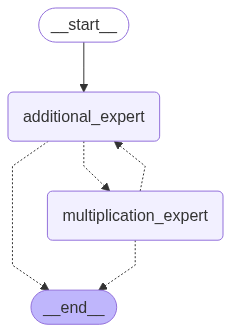

In [29]:

app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
app.invoke({"messages":[("user","what's ((3 + 5) * 12)+2. Provide me the output")]})

*******************addition expert called


{'messages': [HumanMessage(content="what's ((3 + 5) * 12)+2. Provide me the output", additional_kwargs={}, response_metadata={}, id='d7c4a645-230e-4429-9cce-4739bac97d22'),
  AIMessage(content='The result of the expression ((3 + 5) * 12) + 2 is 98.\n\nStep-by-Step Explanation:\n\n1. Solve the parentheses first: 3 + 5 = 8.\n2. Multiply the result by 12: 8 * 12 = 96.\n3. Add 2 to the product: 96 + 2 = 98.\n\nFinal Answer: 98', additional_kwargs={'reasoning_content': "Okay, so I have this math problem to solve: ((3 + 5) * 12) + 2. Hmm, let me break it down step by step. First, I remember that in math problems, I should follow the order of operations, which is parentheses first, then multiplication and division, and finally addition and subtraction. So, looking at the problem, the innermost part is the parentheses: (3 + 5). That seems straightforward. 3 plus 5 is 8. \n\nNow, after solving the parentheses, the problem becomes (8 * 12) + 2. Next up is the multiplication part. So, 8 multiplie

In [57]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [58]:
from dotenv import load_dotenv

In [59]:
load_dotenv()

False

In [60]:
TAVILY_API_KEY="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"


import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [61]:
tavaily_tool=TavilySearchResults()

In [62]:
tavaily_tool.invoke("what is a gdp?")

[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetarymeasure of the total market value( of all the final goods and services produced and rendered in a specific time period by a country( or countries.( GDP is often used to measure the economic performance of a country or region.( Several national and international economic organizations maintain definitions of GDP, such as the OECD and the International Monetary Fund.( [...] GDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\n\nY = C + I + G + (X − M)\nHere is a description of each GDP component: [...] Sustainability of growth – GDP is a measurement of economic historic activity and is not necessarily a projection.\n   Income distribution – GDP does not account for variances in incomes of various demographic groups. See income inequality metrics for discussion of a 

In [63]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [64]:
code = """
x = 5
y = x * 2
print(y)
"""

In [65]:
repl=PythonREPL()

In [66]:
repl.run(code)

'10\n'

In [67]:
members=["researcher","coder"]

In [68]:
options=members+["FINISH"]

In [69]:
options

['researcher', 'coder', 'FINISH']

In [70]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [71]:
class State(MessagesState):
    next:str

In [72]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""

In [73]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [74]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    response = groq_model.with_structured_output(Router).invoke(messages)

    goto = response["next"]

    print("below my goto**********************************")

    print(goto)

    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [75]:
def research_node(state: State) -> Command[Literal["supervisor"]]:

    research_agent = create_react_agent(groq_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")

    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [76]:
def code_node(state: State) -> Command[Literal["supervisor"]]:

    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])

    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [56]:
state.clear

<function dict.clear>

In [77]:
graph=StateGraph(State)

In [78]:
graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START,"supervisor")
app=graph.compile()

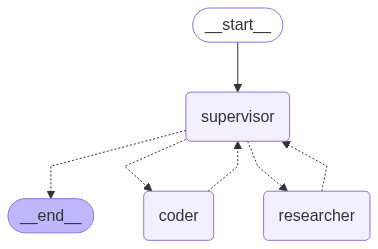

In [79]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [83]:
for s in app.stream({"messages": [("user", "What's the 2*5? use appropriate  tool")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
coder
((), {'supervisor': {'next': 'coder'}})
----
(('coder:4ff2e8de-2c86-83c6-a4d7-65fdee66f4e4',), {'agent': {'messages': [AIMessage(content="To calculate 2 multiplied by 5, I'll use the Python REPL tool to execute the code and get the result.\n\n", additional_kwargs={'reasoning_content': 'Alright, the user is asking "What\'s the 2*5? use appropriate tool." So, they want me to calculate 2 multiplied by 5. I remember I have access to a Python REPL tool, which can execute Python code. \n\nFirst, I need to figure out how to use this tool. The function name is "python_repl_tool" and it requires a code parameter. So, I should create a JSON object with the function name and the code as arguments.\n\nThe calculation is straightforward: 2 * 5. In Python, I can simply print the result using print(2 * 5). This will execute the code and display the output for the user.\n\nI should structure the tool call correctly. The JSON should have "name" set 

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}